In [2]:
%matplotlib inline


Transfer Learning Tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [3]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [4]:
filepath = 'sample11@100.dms'  
with open(filepath) as fp:  
   line = fp.readline()
   cnt = 1
   while line:
       print("cp ../data/src_food/training/{} ../data/food-training-sample".format(line.strip()))
       line = fp.readline()
       cnt += 1

cp ../data/src_food/training/0_0.jpg ../data/food-training-sample
cp ../data/src_food/training/0_116.jpg ../data/food-training-sample
cp ../data/src_food/training/0_122.jpg ../data/food-training-sample
cp ../data/src_food/training/0_123.jpg ../data/food-training-sample
cp ../data/src_food/training/0_125.jpg ../data/food-training-sample
cp ../data/src_food/training/0_130.jpg ../data/food-training-sample
cp ../data/src_food/training/0_136.jpg ../data/food-training-sample
cp ../data/src_food/training/0_14.jpg ../data/food-training-sample
cp ../data/src_food/training/0_150.jpg ../data/food-training-sample
cp ../data/src_food/training/0_161.jpg ../data/food-training-sample
cp ../data/src_food/training/0_170.jpg ../data/food-training-sample
cp ../data/src_food/training/0_202.jpg ../data/food-training-sample
cp ../data/src_food/training/0_210.jpg ../data/food-training-sample
cp ../data/src_food/training/0_212.jpg ../data/food-training-sample
cp ../data/src_food/training/0_213.jpg ../data/food

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train-sample': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5548, 0.4508, 0.3435], [0.2281, 0.2384, 0.2376])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5604, 0.4540, 0.3481], [0.2260, 0.2367, 0.2352])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5604, 0.4540, 0.3481], [0.2260, 0.2367, 0.2352])
    ]),
}

data_dir = '../data/food/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train-sample', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=1)
              for x in ['train-sample', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train-sample', 'val', 'test']}
class_names = image_datasets['train-sample'].classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



tensor([10,  2, 10,  4])


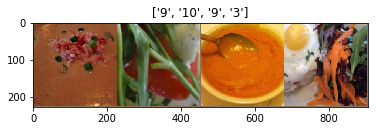

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5548, 0.4508, 0.3435])
    std = np.array([0.2281, 0.2384, 0.2376])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train-sample']))

print(classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train-sample', 'val']:
            if phase == 'train-sample':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train-sample'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train-sample':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            print(epoch_acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print('copy to best')
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 11)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train-sample Loss: 1.8458 Acc: 0.3891
tensor(0.3891, device='cuda:0', dtype=torch.float64)
val Loss: 1.1709 Acc: 0.6207
tensor(0.6207, device='cuda:0', dtype=torch.float64)
copy to best

Epoch 1/24
----------
train-sample Loss: 1.4252 Acc: 0.5400
tensor(0.5400, device='cuda:0', dtype=torch.float64)
val Loss: 1.3870 Acc: 0.6029
tensor(0.6029, device='cuda:0', dtype=torch.float64)

Epoch 2/24
----------
train-sample Loss: 1.3773 Acc: 0.5664
tensor(0.5664, device='cuda:0', dtype=torch.float64)
val Loss: 1.3374 Acc: 0.6283
tensor(0.6283, device='cuda:0', dtype=torch.float64)
copy to best

Epoch 3/24
----------
train-sample Loss: 1.3809 Acc: 0.5627
tensor(0.5627, device='cuda:0', dtype=torch.float64)
val Loss: 1.5416 Acc: 0.6227
tensor(0.6227, device='cuda:0', dtype=torch.float64)

Epoch 4/24
----------
train-sample Loss: 1.2346 Acc: 0.6091
tensor(0.6091, device='cuda:0', dtype=torch.float64)
val Loss: 1.1530 Acc: 0.6685
tensor(0.6685, device='cuda:0', dtype=torch.floa

In [10]:
#save entire model
print('==> Saving model..')
torch.save(model_ft, './retrain-all.pt')
print('Finished Saving')

model_ft = torch.load('./retrain-all.pt')
print('Finished Loading')

==> Saving model..
Finished Saving
Finished Loading


In [9]:
def test(net):
    criterion = nn.CrossEntropyLoss()

    correct = 0
    total = 0
    running_loss = 0.0

    class_correct = list(0. for i in range(11))
    class_total = list(0. for i in range(11))

    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)
        
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
        
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            c = (predicted == labels).squeeze()
            #print(predicted)
            #print(labels.size(0))
            #print(c)
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print('Accuracy of the network on the %d test images: %.2f%%, and loss is: %.3f'
          % (total, 100 * correct / total, running_loss / total))

    class_names = image_datasets['train-sample'].classes
    print(class_names)
    
    for i in range(11):
        print('Accuracy of %5s : %2d %%' % (
            class_names[i], 100 * class_correct[i] / class_total[i]))
    


In [12]:
test(model_ft)

Accuracy of the network on the 3347 test images: 80.13%, and loss is: 0.178
['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']
Accuracy of     0 : 54 %
Accuracy of     1 : 74 %
Accuracy of    10 : 91 %
Accuracy of     2 : 68 %
Accuracy of     3 : 76 %
Accuracy of     4 : 88 %
Accuracy of     5 : 82 %
Accuracy of     6 : 98 %
Accuracy of     7 : 96 %
Accuracy of     8 : 85 %
Accuracy of     9 : 92 %


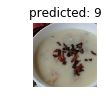

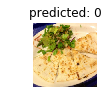

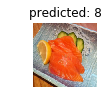

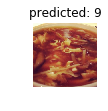

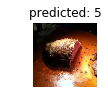

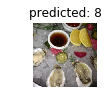

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f3540db8d90>
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/root/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/root/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/root/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/root/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/root/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/root/ana

In [13]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 11)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.5)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train-sample Loss: 2.0430 Acc: 0.3309
tensor(0.3309, device='cuda:0', dtype=torch.float64)
val Loss: 1.2780 Acc: 0.5630
tensor(0.5630, device='cuda:0', dtype=torch.float64)
copy to best

Epoch 1/24
----------
train-sample Loss: 1.5397 Acc: 0.4882
tensor(0.4882, device='cuda:0', dtype=torch.float64)
val Loss: 1.2207 Acc: 0.6128
tensor(0.6128, device='cuda:0', dtype=torch.float64)
copy to best

Epoch 2/24
----------
train-sample Loss: 1.3665 Acc: 0.5636
tensor(0.5636, device='cuda:0', dtype=torch.float64)
val Loss: 1.0518 Acc: 0.6534
tensor(0.6534, device='cuda:0', dtype=torch.float64)
copy to best

Epoch 3/24
----------
train-sample Loss: 1.3418 Acc: 0.5673
tensor(0.5673, device='cuda:0', dtype=torch.float64)
val Loss: 1.0652 Acc: 0.6484
tensor(0.6484, device='cuda:0', dtype=torch.float64)

Epoch 4/24
----------
train-sample Loss: 1.2992 Acc: 0.5791
tensor(0.5791, device='cuda:0', dtype=torch.float64)
val Loss: 0.9541 Acc: 0.6945
tensor(0.6945, device='cuda:0', dty

In [12]:
#save entire model
print('==> Saving model..')
torch.save(model_conv, './retrain-last.pt')
print('Finished Saving')

model_conv = torch.load('./retrain-last.pt')
print('Finished Loading')

==> Saving model..
Finished Saving
Finished Loading


In [13]:
test(model_conv)

Accuracy of the network on the 3347 test images: 74.57%, and loss is: 0.196
['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']
Accuracy of     0 : 67 %
Accuracy of     1 : 77 %
Accuracy of    10 : 83 %
Accuracy of     2 : 57 %
Accuracy of     3 : 65 %
Accuracy of     4 : 70 %
Accuracy of     5 : 73 %
Accuracy of     6 : 97 %
Accuracy of     7 : 93 %
Accuracy of     8 : 75 %
Accuracy of     9 : 90 %


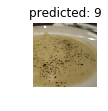

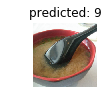

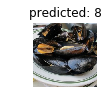

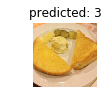

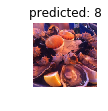

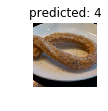

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f3540db8d90>
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/root/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/root/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/root/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/root/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/root/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/root/ana

In [18]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [19]:
model_new = models.resnet18(pretrained=False)
num_ftrs = model_new.fc.in_features
model_new.fc = nn.Linear(num_ftrs, 11)

model_new = model_new.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_new = optim.SGD(model_new.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_new, step_size=10, gamma=0.5)

In [20]:
model_new = train_model(model_new, criterion, optimizer_new, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train-sample Loss: 2.5105 Acc: 0.1391
tensor(0.1391, device='cuda:0', dtype=torch.float64)
val Loss: 2.6071 Acc: 0.1787
tensor(0.1787, device='cuda:0', dtype=torch.float64)
copy to best

Epoch 1/24
----------
train-sample Loss: 2.3733 Acc: 0.1782
tensor(0.1782, device='cuda:0', dtype=torch.float64)
val Loss: 2.2734 Acc: 0.2169
tensor(0.2169, device='cuda:0', dtype=torch.float64)
copy to best

Epoch 2/24
----------
train-sample Loss: 2.3958 Acc: 0.1691
tensor(0.1691, device='cuda:0', dtype=torch.float64)
val Loss: 3.0071 Acc: 0.1904
tensor(0.1904, device='cuda:0', dtype=torch.float64)

Epoch 3/24
----------
train-sample Loss: 2.3645 Acc: 0.1900
tensor(0.1900, device='cuda:0', dtype=torch.float64)
val Loss: 2.3953 Acc: 0.2277
tensor(0.2277, device='cuda:0', dtype=torch.float64)
copy to best

Epoch 4/24
----------
train-sample Loss: 2.3442 Acc: 0.2036
tensor(0.2036, device='cuda:0', dtype=torch.float64)
val Loss: 2.2490 Acc: 0.2423
tensor(0.2423, device='cuda:0', dty

In [22]:
#save entire model
print('==> Saving model..')
torch.save(model_new, './new-train.pt')
print('Finished Saving')

model_new = torch.load('./new-train.pt')
print('Finished Loading')

==> Saving model..
Finished Saving
Finished Loading


In [23]:
test(model_new)

Accuracy of the network on the 3347 test images: 41.29%, and loss is: 0.447
['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']
Accuracy of     0 : 15 %
Accuracy of     1 : 10 %
Accuracy of    10 : 67 %
Accuracy of     2 : 51 %
Accuracy of     3 : 14 %
Accuracy of     4 : 42 %
Accuracy of     5 : 39 %
Accuracy of     6 : 66 %
Accuracy of     7 : 37 %
Accuracy of     8 : 56 %
Accuracy of     9 : 51 %


In [24]:
model_new = train_model(model_new, criterion, optimizer_new, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train-sample Loss: 1.7024 Acc: 0.4300
tensor(0.4300, device='cuda:0', dtype=torch.float64)
val Loss: 1.8074 Acc: 0.4052
tensor(0.4052, device='cuda:0', dtype=torch.float64)
copy to best

Epoch 1/99
----------
train-sample Loss: 1.6982 Acc: 0.4200
tensor(0.4200, device='cuda:0', dtype=torch.float64)
val Loss: 1.8343 Acc: 0.3983
tensor(0.3983, device='cuda:0', dtype=torch.float64)

Epoch 2/99
----------
train-sample Loss: 1.7054 Acc: 0.4027
tensor(0.4027, device='cuda:0', dtype=torch.float64)
val Loss: 1.8476 Acc: 0.4029
tensor(0.4029, device='cuda:0', dtype=torch.float64)

Epoch 3/99
----------
train-sample Loss: 1.7255 Acc: 0.4273
tensor(0.4273, device='cuda:0', dtype=torch.float64)
val Loss: 1.8555 Acc: 0.3971
tensor(0.3971, device='cuda:0', dtype=torch.float64)

Epoch 4/99
----------
train-sample Loss: 1.7170 Acc: 0.4155
tensor(0.4155, device='cuda:0', dtype=torch.float64)
val Loss: 1.8432 Acc: 0.4041
tensor(0.4041, device='cuda:0', dtype=torch.float64)

Epoch 5

val Loss: 1.7682 Acc: 0.4122
tensor(0.4122, device='cuda:0', dtype=torch.float64)

Epoch 42/99
----------
train-sample Loss: 1.7084 Acc: 0.4400
tensor(0.4400, device='cuda:0', dtype=torch.float64)
val Loss: 1.7958 Acc: 0.4114
tensor(0.4114, device='cuda:0', dtype=torch.float64)

Epoch 43/99
----------
train-sample Loss: 1.6793 Acc: 0.4355
tensor(0.4355, device='cuda:0', dtype=torch.float64)
val Loss: 1.7828 Acc: 0.4178
tensor(0.4178, device='cuda:0', dtype=torch.float64)
copy to best

Epoch 44/99
----------
train-sample Loss: 1.7223 Acc: 0.4109
tensor(0.4109, device='cuda:0', dtype=torch.float64)
val Loss: 1.8503 Acc: 0.3968
tensor(0.3968, device='cuda:0', dtype=torch.float64)

Epoch 45/99
----------
train-sample Loss: 1.7489 Acc: 0.4082
tensor(0.4082, device='cuda:0', dtype=torch.float64)
val Loss: 1.8401 Acc: 0.3904
tensor(0.3904, device='cuda:0', dtype=torch.float64)

Epoch 46/99
----------
train-sample Loss: 1.7428 Acc: 0.4018
tensor(0.4018, device='cuda:0', dtype=torch.float64)
va

train-sample Loss: 1.7205 Acc: 0.4355
tensor(0.4355, device='cuda:0', dtype=torch.float64)
val Loss: 1.7541 Acc: 0.4143
tensor(0.4143, device='cuda:0', dtype=torch.float64)

Epoch 84/99
----------
train-sample Loss: 1.7438 Acc: 0.4109
tensor(0.4109, device='cuda:0', dtype=torch.float64)
val Loss: 1.7949 Acc: 0.4149
tensor(0.4149, device='cuda:0', dtype=torch.float64)

Epoch 85/99
----------
train-sample Loss: 1.7075 Acc: 0.4200
tensor(0.4200, device='cuda:0', dtype=torch.float64)
val Loss: 1.8158 Acc: 0.4082
tensor(0.4082, device='cuda:0', dtype=torch.float64)

Epoch 86/99
----------
train-sample Loss: 1.7076 Acc: 0.4191
tensor(0.4191, device='cuda:0', dtype=torch.float64)
val Loss: 1.7437 Acc: 0.4192
tensor(0.4192, device='cuda:0', dtype=torch.float64)

Epoch 87/99
----------
train-sample Loss: 1.7482 Acc: 0.4027
tensor(0.4027, device='cuda:0', dtype=torch.float64)
val Loss: 1.8775 Acc: 0.3915
tensor(0.3915, device='cuda:0', dtype=torch.float64)

Epoch 88/99
----------
train-sample Lo

In [25]:
#save entire model
print('==> Saving model..')
torch.save(model_new, './new-train-100.pt')
print('Finished Saving')

model_new = torch.load('./new-train-100.pt')
print('Finished Loading')

==> Saving model..
Finished Saving
Finished Loading


In [26]:
test(model_new)

Accuracy of the network on the 3347 test images: 42.34%, and loss is: 0.433
['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']
Accuracy of     0 : 14 %
Accuracy of     1 : 13 %
Accuracy of    10 : 79 %
Accuracy of     2 : 36 %
Accuracy of     3 : 11 %
Accuracy of     4 : 47 %
Accuracy of     5 : 44 %
Accuracy of     6 : 63 %
Accuracy of     7 : 42 %
Accuracy of     8 : 65 %
Accuracy of     9 : 55 %
